## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## learning curve based on number of samples

#### Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')

#### define function for learning curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title(title)
    
    plt.legend(loc="best")

    return plt

#### only 10% of dataset

In [ ]:
# X = X[::3, :]
# y = y[::3]
X.shape

(841005, 186)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


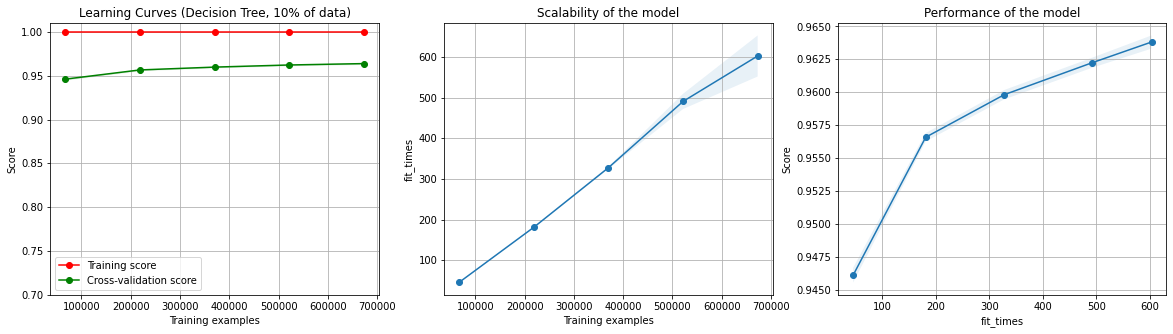

In [ ]:
title = r"Learning Curves (Decision Tree, 10% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 1% of dataset

In [ ]:
X = X[::10, :]
y = y[::10]

In [ ]:
X.shape

(84101, 186)

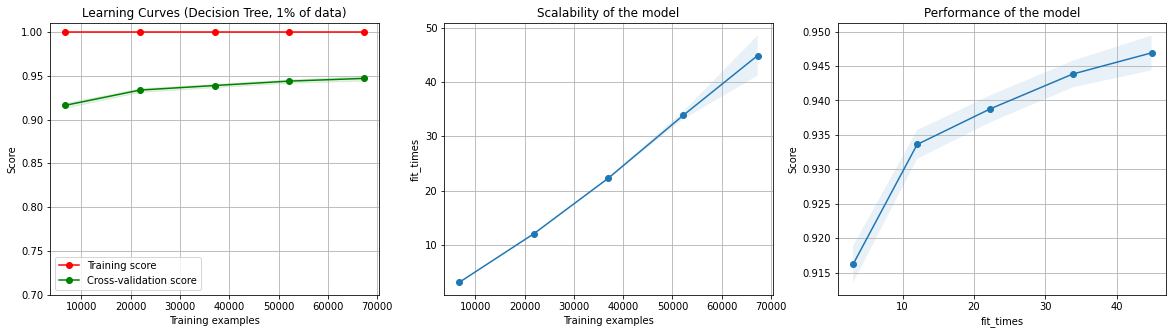

In [ ]:
title = r"Learning Curves (Decision Tree, 1% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 0.1% of data

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(8411, 186)

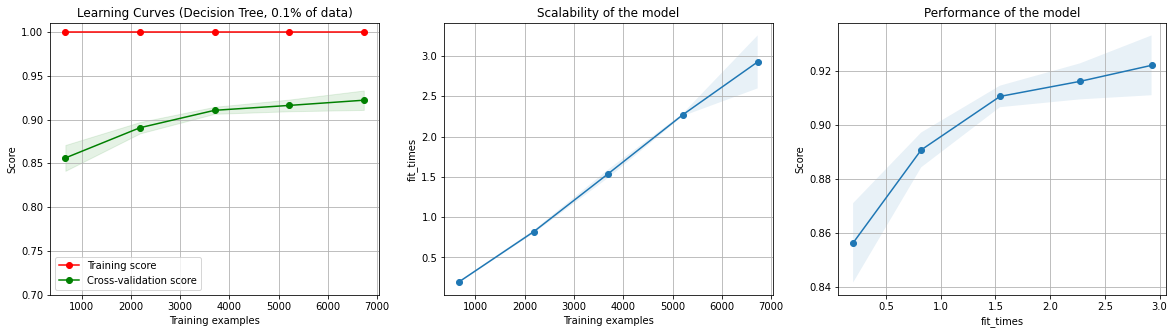

In [ ]:
title = r"Learning Curves (Decision Tree, 0.1% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

## load data and build DT basd on entropy 10% of data

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy')

In [ ]:
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

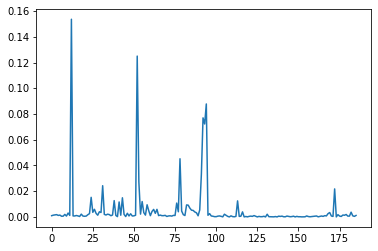

In [ ]:
# plt.figure(figsize=(15, 5))
# plt.scatter(np.arange(186)+1, clf.feature_importances_)
plt.plot(clf.feature_importances_)

No handles with labels found to put in legend.


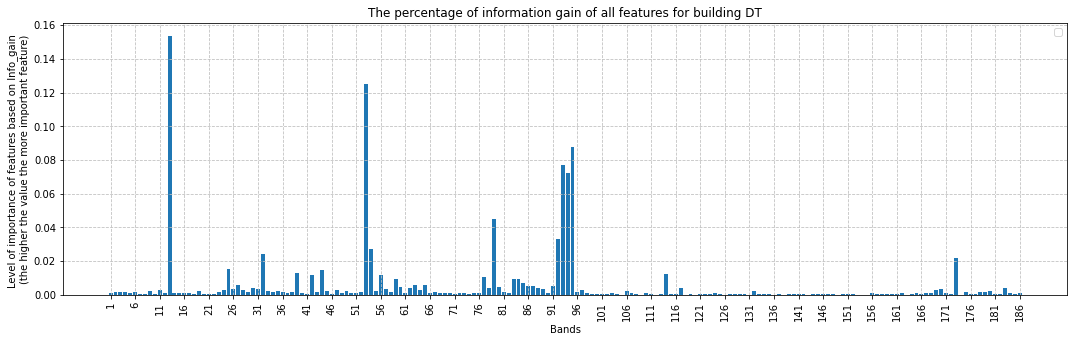

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, clf.feature_importances_)
plt.xlabel('Bands')
plt.ylabel('Level of importance of features based on Info_gain \n(the higher the value the more important feature)')
plt.title('The percentage of information gain of all features for building DT')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.legend(loc="best")
plt.show()

In [ ]:
ordered_bands = pd.DataFrame()

In [ ]:
ordered_bands.insert(loc=ordered_bands.shape[1], column='steps', value=np.arange(186)+1)
ordered_bands.insert(loc=ordered_bands.shape[1], column='band_list', value=columns)
ordered_bands.insert(loc=ordered_bands.shape[1], column='importance', value=clf.feature_importances_)

In [ ]:
ordered_bands.sort_values(by=['importance'], inplace=True, ascending=False)

In [ ]:
ordered_bands.head(10)

,steps,band_list,importance
12,13,Band_013,0.153663
52,53,Band_053,0.125022
94,95,Band_095,0.087812
92,93,Band_093,0.077001
93,94,Band_094,0.072239
78,79,Band_079,0.045212
91,92,Band_092,0.033324
53,54,Band_054,0.027217
31,32,Band_032,0.024268
172,173,Band_173,0.021775


In [ ]:
bands_list = ordered_bands.band_list.values

## learning curves for filter methods

### load dataset and keep 1% for training purpose

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
df = pd.DataFrame(data=X, columns=columns)
df.head(3)

,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,Band_039,Band_040,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,0.055364,0.071277,0.062560,0.062931,0.073905,0.055737,0.062921,0.060123,0.056552,0.062749,0.059414,0.059066,0.066134,0.064663,0.062497,0.063313,0.062573,0.063923,0.072067,0.061628,0.068952,0.069534,0.063854,0.063532,0.063523,0.063333,0.066438,0.065995,0.068486,0.067091,0.065591,0.069869,0.071611,0.071547,0.075075,0.079294,0.077710,0.074765,0.081016,0.080989,...,0.256003,0.244539,0.252226,0.255288,0.258960,0.255068,0.257223,0.266414,0.260323,0.269098,0.268707,0.262175,0.269845,0.263428,0.276127,0.277523,0.279097,0.271806,0.286093,0.284609,0.276917,0.290901,0.271737,0.296084,0.287388,0.288105,0.297305,0.287817,0.293130,0.280577,0.294222,0.307158,0.299976,0.291312,0.304959,0.295205,0.289494,0.300307,0.298140,0.306262
1,0.074993,0.072435,0.064133,0.080734,0.088216,0.070953,0.067431,0.068336,0.079696,0.081326,0.072144,0.064534,0.071140,0.076132,0.076926,0.073100,0.068827,0.075382,0.074642,0.074307,0.076571,0.078271,0.073199,0.074093,0.081167,0.073853,0.073868,0.075267,0.083201,0.082551,0.086952,0.093180,0.105580,0.112416,0.123468,0.129664,0.151454,0.161905,0.169379,0.175393,...,0.505026,0.494720,0.483715,0.488838,0.488722,0.487259,0.482478,0.480058,0.500768,0.489220,0.471241,0.482861,0.477204,0.484921,0.481572,0.477932,0.482379,0.469481,0.480970,0.455296,0.474330,0.453260,0.479589,0.466238,0.457954,0.463635,0.447302,0.468616,0.465824,0.460319,0.453349,0.457308,0.448119,0.459175,0.454227,0.460216,0.452923,0.471841,0.476259,0.469941
2,0.045479,0.042046,0.037275,0.043536,0.034465,0.042052,0.041346,0.036096,0.037316,0.034090,0.038630,0.037338,0.038530,0.039467,0.037237,0.036758,0.041296,0.038946,0.038131,0.033877,0.036581,0.036654,0.043430,0.040508,0.038260,0.039300,0.039091,0.035584,0.043376,0.038516,0.041190,0.044052,0.045166,0.049253,0.055280,0.056265,0.060899,0.063739,0.068785,0.068890,...,0.180802,0.178378,0.176781,0.181192,0.180998,0.177616,0.173728,0.184667,0.180696,0.179134,0.180556,0.175598,0.176941,0.179723,0.179929,0.182357,0.179584,0.178325,0.181278,0.178470,0.181702,0.175787,0.171325,0.178576,0.181164,0.177727,0.170604,0.175006,0.180909,0.169396,0.169240,0.168891,0.165199,0.170660,0.173753,0.182452,0.168766,0.164232,0.174707,0.171867


#### order dataset based on entropy

In [ ]:
# read learning curve tabel from the csv file
df_lc = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_LR.csv')
df_lc = df_lc.iloc[:, 1:]
# df.tail()
bands_list = df_lc.ordered_bands.values

In [ ]:
X = np.zeros((df.shape), dtype='float32')

In [ ]:
for i in range(186):
  X[:, i:i+1] = np.array(df[bands_list[i]].values.reshape(-1, 1), dtype='float32')

### logistic regression on filter method (entropy)

In [ ]:
%%time

num_of_folds = 5
# kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

# X = np.array(df[bands_list[0]].values.reshape(-1, 1), dtype='float32')
# y = np.array(y, dtype='int')

train_scores_mean_arr = np.array([])
train_scores_std_arr = np.array([])
val_scores_mean_arr = np.array([])
val_scores_std_arr = np.array([])

train_scores = np.array([])
val_scores = np.array([])


for i in range(0, 186):

  # instantiate cross_validation instance
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

  train_scores = np.array([])
  val_scores = np.array([])

  for train_index, val_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[:, 0:i+1][train_index], X[:, 0:i+1][val_index]
    y_train, y_val = y[train_index], y[val_index]

    # clf = LogisticRegression(penalty='none', max_iter=500).fit(X_train, y_train)
    clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', max_iter=1000))
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)

    train_scores = np.append(train_scores, train_score)
    val_scores = np.append(val_scores, val_score)

  train_scores_mean = np.mean(train_scores)
  train_scores_std = np.std(train_scores)
  val_scores_mean = np.mean(val_scores)
  val_scores_std = np.std(val_scores)

  train_scores_mean_arr = np.append(train_scores_mean_arr, train_scores_mean)
  train_scores_std_arr = np.append(train_scores_std_arr, train_scores_std)
  val_scores_mean_arr = np.append(val_scores_mean_arr, val_scores_mean)
  val_scores_std_arr = np.append(val_scores_std_arr, val_scores_std)

  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
CPU times: user 9h 56min 24s, sys: 2h 9min 33s, total: 12h 5min 58s
Wall time: 6h 9min 49s


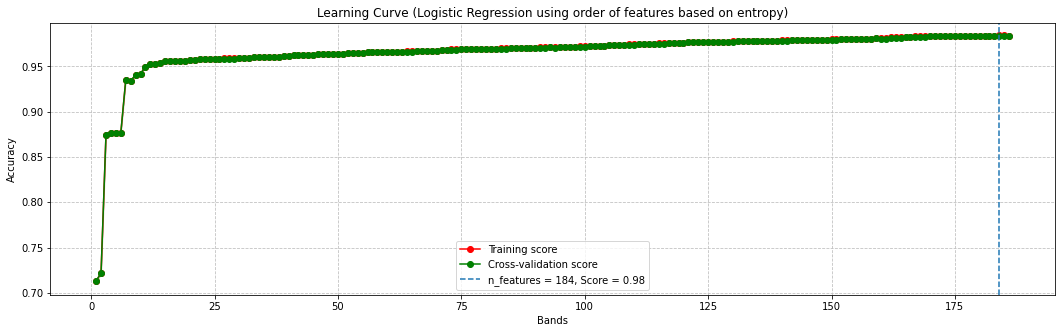

In [ ]:
steps = np.arange(186) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Logistic Regression using order of features based on entropy)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
steps = np.arange(186) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list[0:186], allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

In [ ]:
# save learning curve into a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_LR.csv')

In [ ]:
# read learning curve tabel from the csv file
df = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_LR.csv')
df = df.iloc[:, 1:]
df.tail()

,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
181,182,Band_111,0.983900,0.000105,0.983436,0.000231
182,183,Band_139,0.983969,0.000118,0.983454,0.000266
183,184,Band_135,0.984034,0.000131,0.983496,0.000246
184,185,Band_109,0.984009,0.000085,0.983436,0.000275
185,186,Band_116,0.983978,0.000120,0.983454,0.000265


### RF on filter method (entropy)

##### best hyperparameters

In [ ]:
clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
param_grid = [{'n_estimators': [50, 100, 200],
               'criterion':['gini', 'entropy'] ,
               'max_depth': [2, 5, 20, 80, 'None'],}]

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=2,
                           n_jobs = -1)
grid_search = grid_search.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 46.2min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 335.7min finished


In [ ]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 80, 'n_estimators': 200}

In [ ]:
grid_search.best_score_

0.9274142112416545

#### fit

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
CPU times: user 1d 1h 48min 47s, sys: 1min 34s, total: 1d 1h 50min 22s
Wall time: 13h 10min 6s


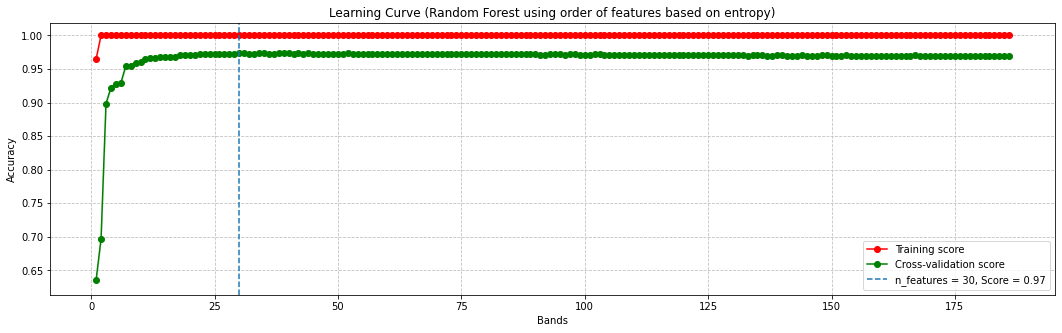

In [ ]:
steps = np.arange(186) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest using order of features based on entropy)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
steps = np.arange(186) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list[0:186], allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

In [ ]:
# save learning curve into a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_RF.csv')

In [ ]:
# read learning curve tabel from the csv file
df = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_RF.csv')
df = df.iloc[:, 1:]
df.tail()

,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
181,182,Band_111,1.000000,0.000000,0.969656,0.002103
182,183,Band_139,1.000000,0.000000,0.969287,0.002276
183,184,Band_135,0.999997,0.000006,0.969287,0.001761
184,185,Band_109,1.000000,0.000000,0.969703,0.001453
185,186,Band_116,1.000000,0.000000,0.969323,0.002181


### SVM on filter method (entropy)

#### stochastic

In [ ]:
%%time

num_of_folds = 50
# kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

# X = np.array(df[bands_list[0]].values.reshape(-1, 1), dtype='float32')
# y = np.array(y, dtype='int')

train_scores_mean_arr = np.array([])
train_scores_std_arr = np.array([])
val_scores_mean_arr = np.array([])
val_scores_std_arr = np.array([])

train_scores = np.array([])
val_scores = np.array([])


for i in range(0, 186):

  # instantiate cross_validation instance
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

  train_scores = np.array([])
  val_scores = np.array([])

  for train_index, val_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[:, 0:i+1][train_index], X[:, 0:i+1][val_index]
    y_train, y_val = y[train_index], y[val_index]

    # clf = support vector machines
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, n_jobs=-1))
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)

    train_scores = np.append(train_scores, train_score)
    val_scores = np.append(val_scores, val_score)

  train_scores_mean = np.mean(train_scores)
  train_scores_std = np.std(train_scores)
  val_scores_mean = np.mean(val_scores)
  val_scores_std = np.std(val_scores)

  train_scores_mean_arr = np.append(train_scores_mean_arr, train_scores_mean)
  train_scores_std_arr = np.append(train_scores_std_arr, train_scores_std)
  val_scores_mean_arr = np.append(val_scores_mean_arr, val_scores_mean)
  val_scores_std_arr = np.append(val_scores_std_arr, val_scores_std)

  print(i)


steps = np.arange(186) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list, allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

# save learning curve into a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM_stochastic.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
CPU times: user 4h 2min, sys: 18min 34s, total: 4h 20min 34s
Wall time: 3h 59min 49s


In [ ]:
steps = np.arange(186) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list, allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

# # save learning curve into a csv file
# df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM_stochastic.csv')

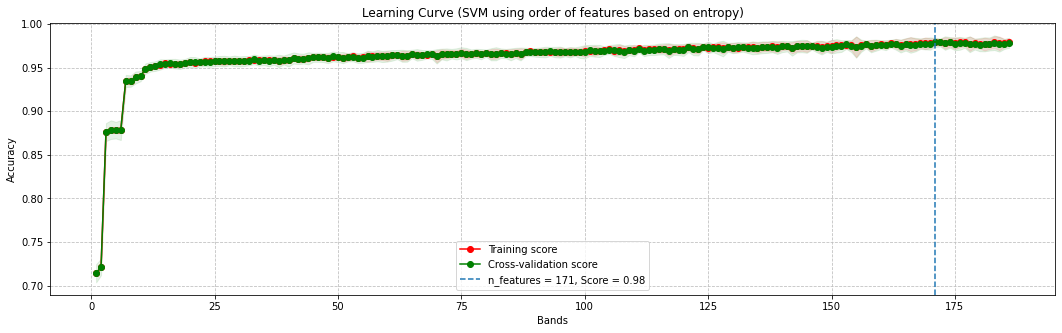

In [ ]:
steps = np.arange(186) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM using order of features based on entropy)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

#### normal

In [ ]:
%%time

num_of_folds = 5
# kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

# X = np.array(df[bands_list[0]].values.reshape(-1, 1), dtype='float32')
# y = np.array(y, dtype='int')

train_scores_mean_arr = np.array([])
train_scores_std_arr = np.array([])
val_scores_mean_arr = np.array([])
val_scores_std_arr = np.array([])

train_scores = np.array([])
val_scores = np.array([])


for i in range(0, 80):

  # instantiate cross_validation instance
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

  train_scores = np.array([])
  val_scores = np.array([])

  for train_index, val_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[:, 0:i+1][train_index], X[:, 0:i+1][val_index]
    y_train, y_val = y[train_index], y[val_index]

    # clf = support vector machines
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)

    train_scores = np.append(train_scores, train_score)
    val_scores = np.append(val_scores, val_score)

  train_scores_mean = np.mean(train_scores)
  train_scores_std = np.std(train_scores)
  val_scores_mean = np.mean(val_scores)
  val_scores_std = np.std(val_scores)

  train_scores_mean_arr = np.append(train_scores_mean_arr, train_scores_mean)
  train_scores_std_arr = np.append(train_scores_std_arr, train_scores_std)
  val_scores_mean_arr = np.append(val_scores_mean_arr, val_scores_mean)
  val_scores_std_arr = np.append(val_scores_std_arr, val_scores_std)

  print(i)

steps = np.arange(80) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list[0:80], allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

# save learning curve into a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
CPU times: user 17h 23min 18s, sys: 1min 52s, total: 17h 25min 10s
Wall time: 17h 26min 51s


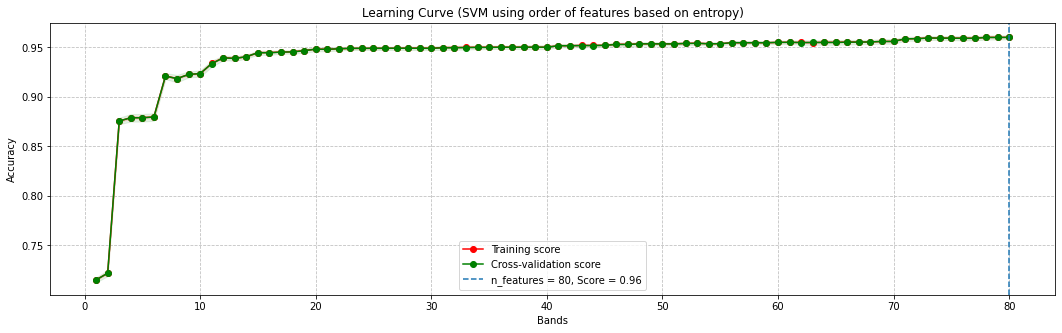

In [ ]:
steps = np.arange(80) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM using order of features based on entropy)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
# steps = np.arange(186) + 1
# df = pd.DataFrame(data=steps, columns=['steps'])
# df.insert(loc=1, column='ordered_bands', value=bands_list[0:186], allow_duplicates=True)
# df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
# df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
# df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
# df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

In [ ]:
# # save learning curve into a csv file
# df.to_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM.csv')

In [ ]:
# read learning curve tabel from the csv file
df = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM.csv')
df = df.iloc[:, 1:]
df.tail()

,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
75,76,Band_172,0.959364,0.000264,0.959192,0.002142
76,77,Band_165,0.959338,0.000294,0.959204,0.002147
77,78,Band_003,0.960229,0.000423,0.960024,0.002158
78,79,Band_037,0.960191,0.000435,0.960060,0.002111
79,80,Band_075,0.960229,0.000443,0.960155,0.002003


In [ ]:
# train_scores_mean_arr = df.train_scores_mean.values
# train_scores_std_arr = df.train_scores_std.values
# val_scores_mean_arr = df.val_scores_mean.values
# val_scores_std_arr = df.val_scores_std.values

#### Grid Search CV for tuning hyper parameters of SVM

In [ ]:
X.shape

(84101, 186)

In [ ]:
clf = SVC()

In [ ]:
param_grid = [{'kernel':['linear'], 'C': [0.1, 0.5, 1, 10, 50]},
              {'kernel':['rbf'], 'C': [0.1, 0.5, 1, 10, 50], 'gamma': ['scale', 'auto']}]

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose = 2,
                           n_jobs = -1)
grid_search = grid_search.fit(X[:, 0:20], y) # just 20 channels

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 109.3min finished


In [ ]:
best_estimator = grid_search.best_estimator_

In [ ]:
grid_search.best_score_

0.9317490699617382

In [ ]:
grid_search.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
grid_search.cv_results_['mean_test_score']

array([0.89236683, 0.91531563, 0.91991731, 0.92430497, 0.92418606,
       0.92454275, 0.82260559, 0.93115405, 0.87620765, 0.93101144,
       0.89319916, 0.9316657 , 0.92190299, 0.93174907, 0.92576747])

In [ ]:
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 0.5, 1, 10, 50], 'kernel': ['linear']},
                         {'C': [0.1, 0.5, 1, 10, 50],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([231.3346477 , 115.94754376, 103.63188624,  61.5370862 ,
         54.47283807, 122.46241813, 494.84482455,  83.06801133,
        390.42087212,  68.95664067, 323.11219459,  46.50941362,
        120.79642801,  40.80959048,  84.44567966]),
 'mean_score_time': array([16.71002293, 10.80796928,  9.08328838,  5.77403274,  4.74181991,
        19.70392699, 59.50867429, 12.74300957, 41.70206175, 10.87281599,
        34.75811386,  7.19957356, 18.58348179,  5.87802773, 12.04826736]),
 'mean_test_score': array([0.89236683, 0.91531563, 0.91991731, 0.92430497, 0.92418606,
        0.92454275, 0.82260559, 0.93115405, 0.87620765, 0.93101144,
        0.89319916, 0.9316657 , 0.92190299, 0.93174907, 0.92576747]),
 'param_C': masked_array(data=[0.1, 0.5, 1, 10, 50, 0.1, 0.1, 0.5, 0.5, 1, 1, 10, 10,
                    50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'auto'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


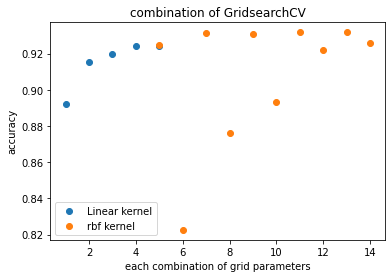

In [ ]:
plt.scatter(np.arange(5)+1,grid_search.cv_results_['mean_test_score'][:5], label='Linear kernel')
plt.scatter(np.arange(10)+5,grid_search.cv_results_['mean_test_score'][5:], label='rbf kernel')
plt.title('combination of GridsearchCV')
plt.xlabel('each combination of grid parameters')
plt.ylabel('accuracy')
plt.legend(loc='auto')
plt.show()

### all in one

In [ ]:
df_lr = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_LR.csv')
df_rf = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_RF.csv')
# df_svm = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM.csv')
df_svm2 = pd.read_csv('/content/drive/MyDrive/Thesis/results/filters/leanrning_curve_entropy_SVM_stochastic.csv')

In [ ]:
lr_train_scores_mean_arr = df_lr.train_scores_mean.values
lr_train_scores_std_arr = df_lr.train_scores_std.values
lr_val_scores_mean_arr = df_lr.val_scores_mean.values
lr_val_scores_std_arr = df_lr.val_scores_std.values

rf_train_scores_mean_arr = df_rf.train_scores_mean.values
rf_train_scores_std_arr = df_rf.train_scores_std.values
rf_val_scores_mean_arr = df_rf.val_scores_mean.values
rf_val_scores_std_arr = df_rf.val_scores_std.values

# svm_train_scores_mean_arr = df_svm.train_scores_mean.values
# svm_train_scores_std_arr = df_svm.train_scores_std.values
# svm_val_scores_mean_arr = df_svm.val_scores_mean.values
# svm_val_scores_std_arr = df_svm.val_scores_std.values

svm_train_scores_mean_arr2 = df_svm2.train_scores_mean.values
svm_train_scores_std_arr2 = df_svm2.train_scores_std.values
svm_val_scores_mean_arr2 = df_svm2.val_scores_mean.values
svm_val_scores_std_arr2 = df_svm2.val_scores_std.values

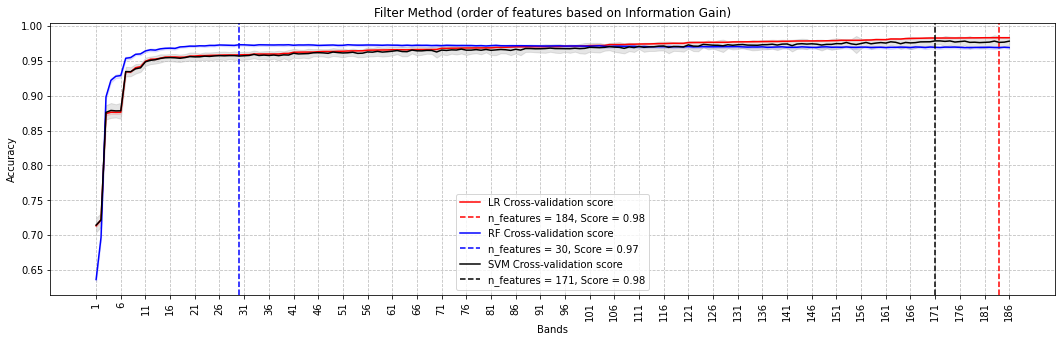

In [ ]:
steps_lr = np.arange(len(lr_train_scores_mean_arr)) + 1
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1
# steps_svm = np.arange(len(svm_train_scores_mean_arr)) + 1
steps_svm2 = np.arange(len(svm_train_scores_mean_arr2)) + 1

plt.figure(figsize=(18, 5))

# logistic regression
# plt.fill_between(steps_lr, lr_train_scores_mean_arr - lr_train_scores_std_arr,
#                  lr_train_scores_mean_arr + lr_train_scores_std_arr, alpha=0.1, color="green")
plt.fill_between(steps_lr, lr_val_scores_mean_arr - lr_val_scores_std_arr,
                 lr_val_scores_mean_arr + lr_val_scores_std_arr, alpha=0.1, color="red")
# plt.plot(steps_lr, lr_train_scores_mean_arr, '--', color="green", label="LR Training score")
plt.plot(steps_lr, lr_val_scores_mean_arr, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=lr_val_scores_mean_arr.argmax() + 1, color="red", ls='--', label='n_features = {}, Score = {}'.format(lr_val_scores_mean_arr.argmax()+1, round(lr_val_scores_mean_arr.max(), 2)))

# random forest
# plt.fill_between(steps_rf, rf_train_scores_mean_arr - rf_train_scores_std_arr,
#                  rf_train_scores_mean_arr + rf_train_scores_std_arr, alpha=0.1, color="blue")
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
# plt.plot(steps_rf, rf_train_scores_mean_arr, '--', color="blue", label="RF Training score")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, color="blue", ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

# # svm
# plt.fill_between(steps_svm, svm_train_scores_mean_arr - svm_train_scores_std_arr,
#                  svm_train_scores_mean_arr + svm_train_scores_std_arr, alpha=0.1, color="orange")
# plt.fill_between(steps_svm, svm_val_scores_mean_arr - svm_val_scores_std_arr,
#                  svm_val_scores_mean_arr + svm_val_scores_std_arr, alpha=0.1, color="gray")
# plt.plot(steps_svm, svm_train_scores_mean_arr, '--', color="orange", label="SVM Training score")
# plt.plot(steps_svm, svm_val_scores_mean_arr, '-', color="gray", label="SVM Cross-validation score")
# plt.axvline(x=svm_val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr.argmax()+1, round(svm_val_scores_mean_arr.max(), 2)))

# svm
# plt.fill_between(steps_svm2, svm_train_scores_mean_arr2 - svm_train_scores_std_arr2,
#                  svm_train_scores_mean_arr2 + svm_train_scores_std_arr2, alpha=0.1, color="Magenta")
plt.fill_between(steps_svm2, svm_val_scores_mean_arr2 - svm_val_scores_std_arr2,
                 svm_val_scores_mean_arr2 + svm_val_scores_std_arr2, alpha=0.1, color="black")
# plt.plot(steps_svm2, svm_train_scores_mean_arr2, '--', color="Magenta", label="SVM SGD classifier Training score")
plt.plot(steps_svm2, svm_val_scores_mean_arr2, '-', color="black", label="SVM Cross-validation score")
plt.axvline(x=svm_val_scores_mean_arr2.argmax() + 1, color="black", ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr2.argmax()+1, round(svm_val_scores_mean_arr2.max(), 2)))

plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Filter Method (order of features based on Information Gain)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
df_lr.head(3)

,Unnamed: 0,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
0,0,1,Band_013,0.713124,0.000538,0.713135,0.001603
1,1,2,Band_053,0.721900,0.000623,0.722023,0.002108
2,2,3,Band_095,0.874406,0.000662,0.874406,0.002717


In [ ]:
df = pd.DataFrame(data=np.zeros((186, 3)), columns=['LR', 'RF', 'SVM'])
df.iloc[:df_lr.val_scores_mean.argmax()+1,0:1] = np.arange(1, df_lr.val_scores_mean.argmax()+2).reshape((-1, 1))
df.iloc[:df_rf.val_scores_mean.argmax()+1,1:2] = np.arange(1, df_rf.val_scores_mean.argmax()+2).reshape((-1, 1))
df.iloc[:df_svm2.val_scores_mean.argmax()+1,2:3] = np.arange(1, df_svm2.val_scores_mean.argmax()+2).reshape((-1, 1))
df.insert(loc=0, column='features', value=df_lr.ordered_bands.values)
df.sort_values(by='features', inplace=True)
df.head()

,features,LR,RF,SVM
88,Band_001,89.0,0.0,89.0
86,Band_002,87.0,0.0,87.0
77,Band_003,78.0,0.0,78.0
103,Band_004,104.0,0.0,104.0
94,Band_005,95.0,0.0,95.0


In [ ]:
df.iloc[:, 1:] = np.abs(df.iloc[:, 1:] - 186)
df.loc[(df['LR'] == 186), 'LR'] = 0
df.loc[(df['RF'] == 186), 'RF'] = 0
df.loc[(df['SVM'] == 186), 'SVM'] = 0
df.head()

,features,LR,RF,SVM
88,Band_001,97.0,0.0,97.0
86,Band_002,99.0,0.0,99.0
77,Band_003,108.0,0.0,108.0
103,Band_004,82.0,0.0,82.0
94,Band_005,91.0,0.0,91.0


In [ ]:
info_gain = df_lr.iloc[:, 1:3]
info_gain.head(3)

,steps,ordered_bands
0,1,Band_013
1,2,Band_053
2,3,Band_095


In [ ]:
info_gain.steps = 187 - info_gain.steps

In [ ]:
info_gain.head(3)

,steps,ordered_bands
0,186,Band_013
1,185,Band_053
2,184,Band_095


In [ ]:
info_gain.sort_values(by='ordered_bands', ascending=True, inplace=True)
info_gain.head(3)

,steps,ordered_bands
88,98,Band_001
86,100,Band_002
77,109,Band_003


No handles with labels found to put in legend.


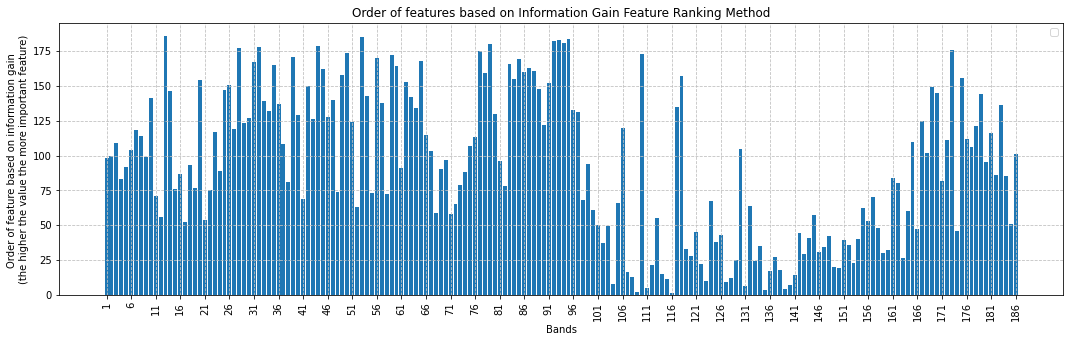

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, info_gain.steps)
plt.xlabel('Bands')
plt.ylabel('Order of feature based on information gain \n(the higher the value the more important feature)')
plt.title('Order of features based on Information Gain Feature Ranking Method')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.legend(loc="best")
plt.show()

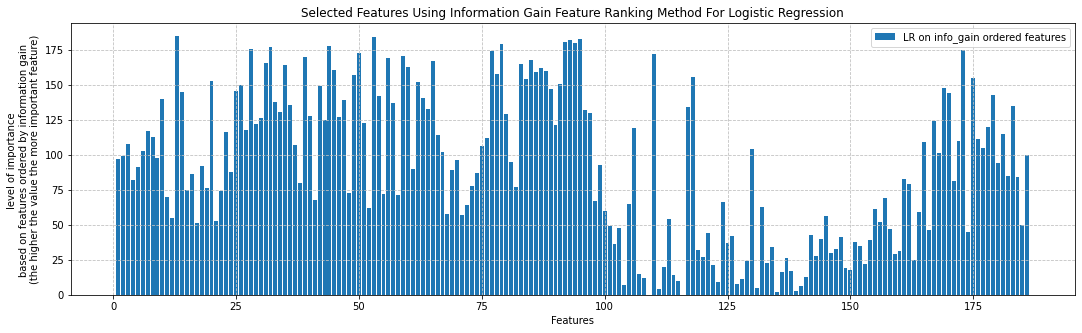

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.LR, label="LR on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

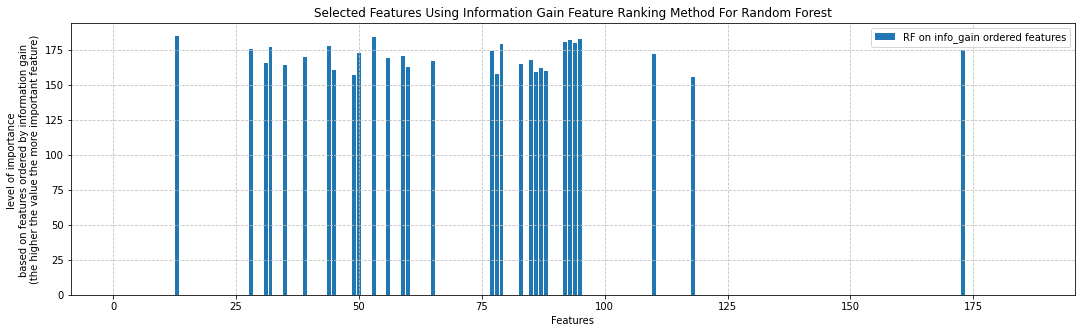

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.RF, label="RF on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

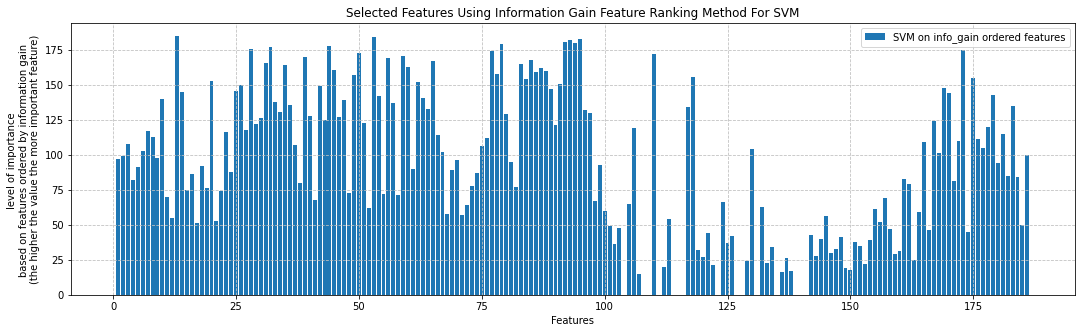

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SVM, label="SVM on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For SVM')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

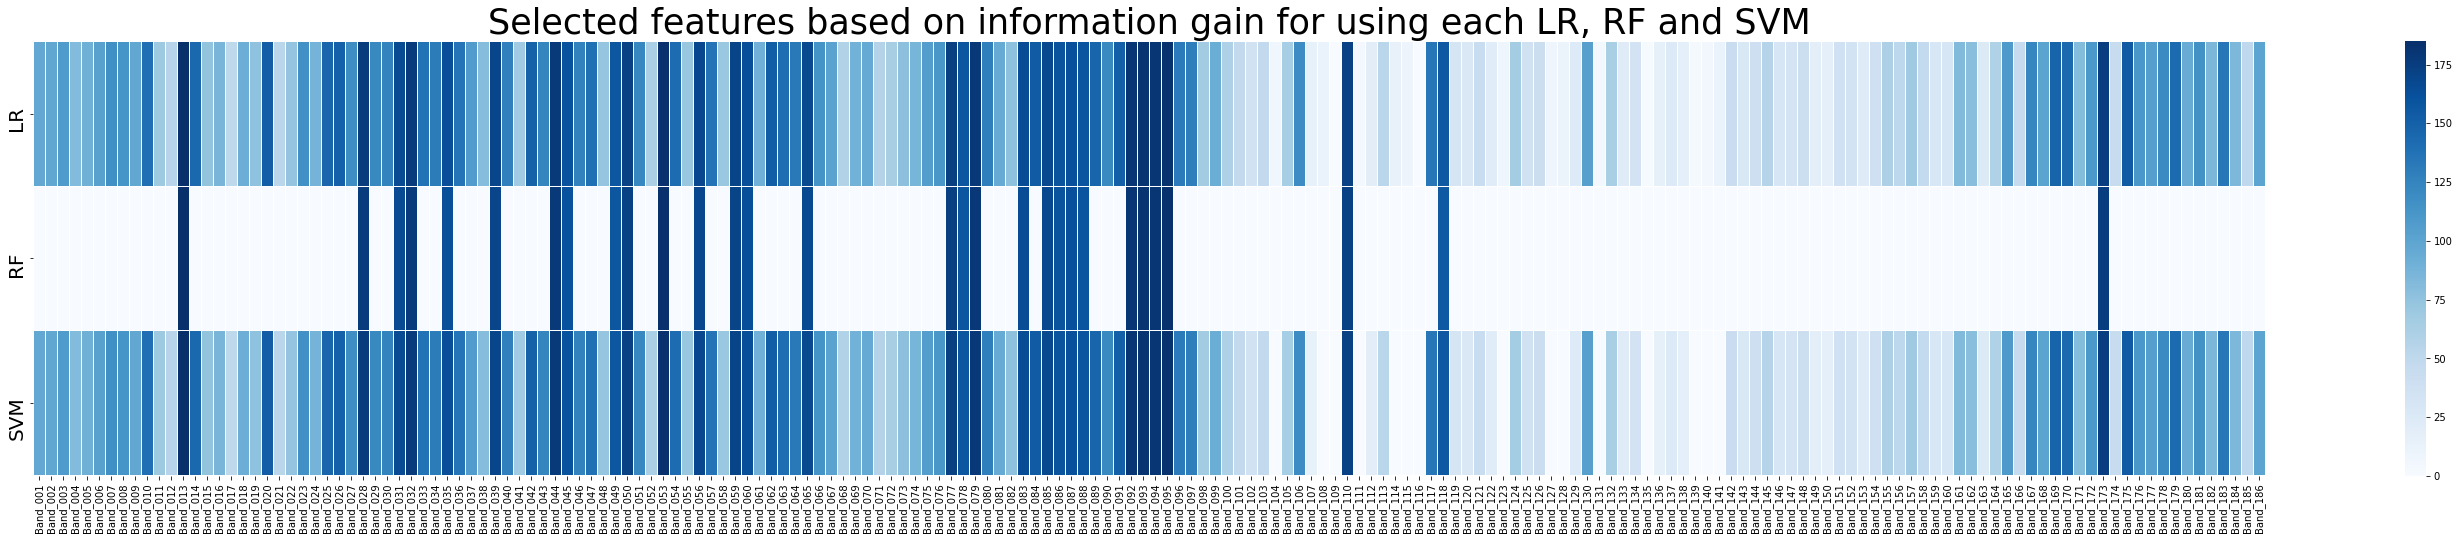

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features based on information gain for using each LR, RF and SVM', fontsize=35)
plt.yticks(fontsize=20)

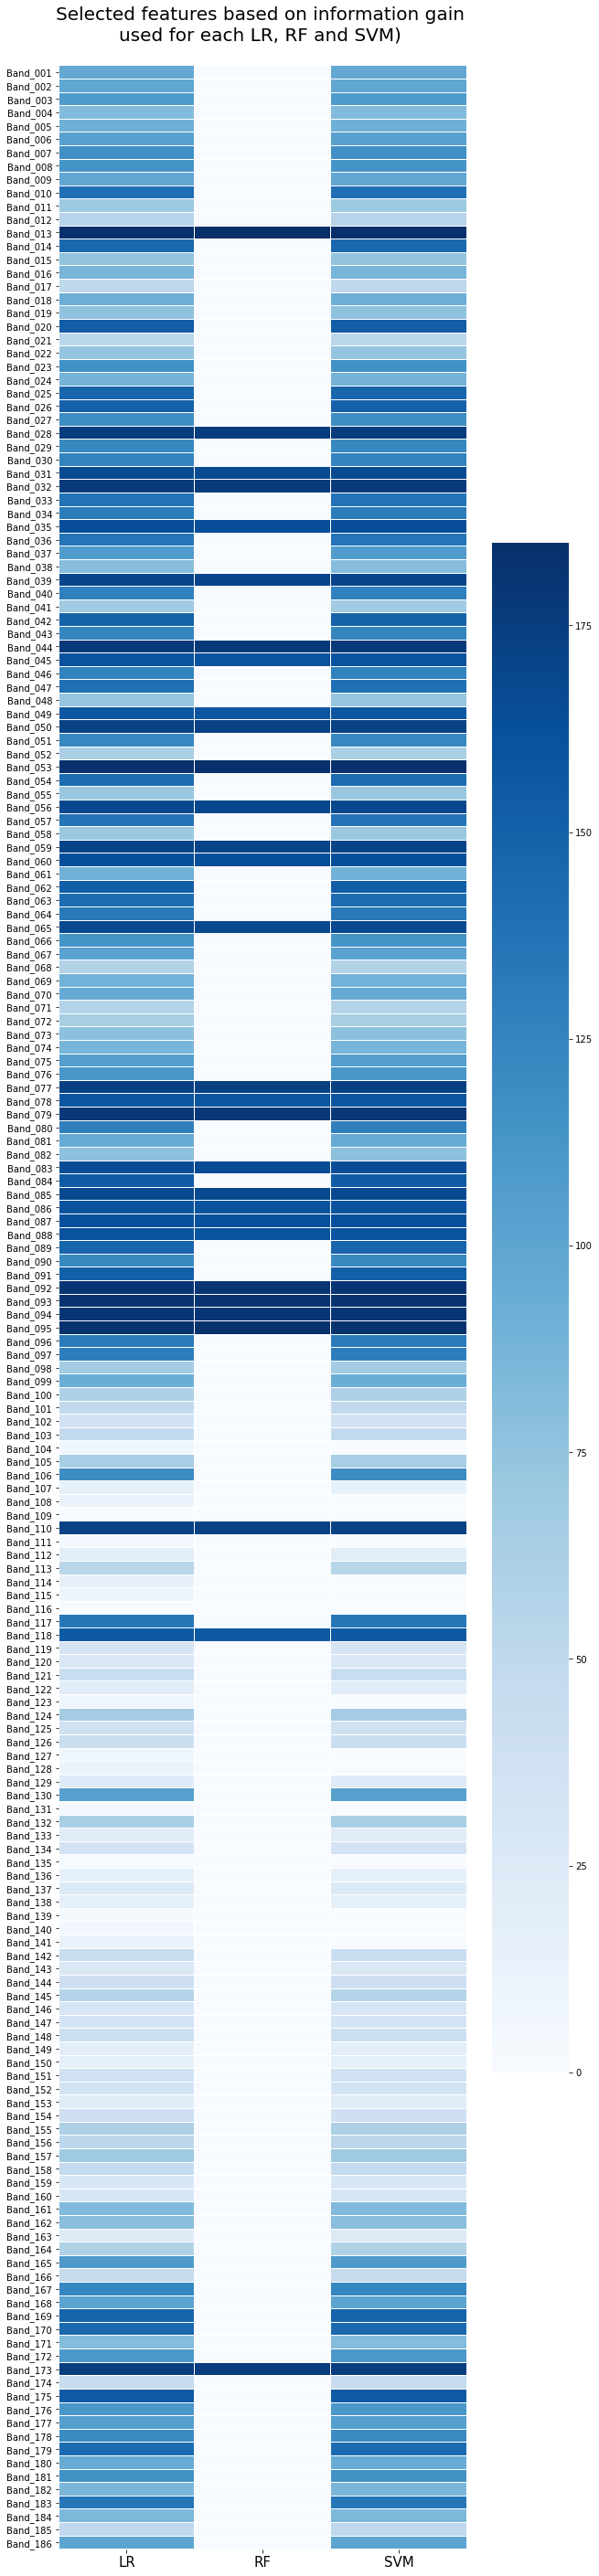

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features based on information gain \nused for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


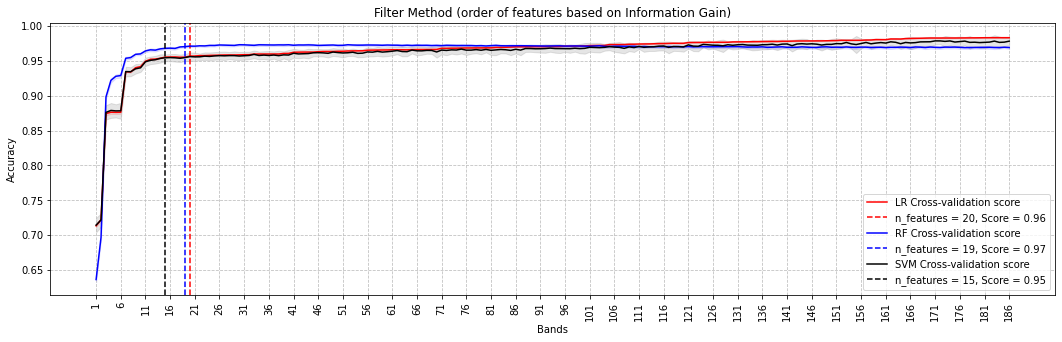

In [ ]:
stopping_critera = 0.002
steps_lr = np.arange(len(lr_train_scores_mean_arr)) + 1
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1
steps_svm2 = np.arange(len(svm_train_scores_mean_arr2)) + 1

plt.figure(figsize=(18, 5))

########################### logistic regression ########################### 
plt.fill_between(steps_lr, lr_val_scores_mean_arr - lr_val_scores_std_arr,
                 lr_val_scores_mean_arr + lr_val_scores_std_arr, alpha=0.1, color="red")
plt.plot(steps_lr, lr_val_scores_mean_arr, '-', color="red", label="LR Cross-validation score")
# plt.axvline(x=lr_val_scores_mean_arr.argmax() + 1, color="red", ls='--', label='n_features = {}, Score = {}'.format(lr_val_scores_mean_arr.argmax()+1, round(lr_val_scores_mean_arr.max(), 2)))

# selected features based on new stopping criteria
LR_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_lr.val_scores_mean[i+9:i+10].values, df_lr.val_scores_mean[i:i+1].values) < stopping_critera:
    LR_filtered_features_index = np.append(LR_filtered_features_index, i)
LR_number_features = LR_filtered_features_index.min() + 1

plt.axvline(x=int(LR_number_features), ls='--', color="red", label='n_features = {}, Score = {}'.format(int(LR_number_features), str(round(df_lr.val_scores_mean[int(LR_number_features)], 2))))

############################  random forest ##############################
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, color="blue", ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

# selected features based on new stopping criteria
RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_rf.val_scores_mean[i+9:i+10].values, df_rf.val_scores_mean[i:i+1].values) < stopping_critera:
    RF_filtered_features_index = np.append(RF_filtered_features_index, i)
RF_number_features = RF_filtered_features_index.min() + 1

plt.axvline(x=int(RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(RF_number_features), str(round(df_rf.val_scores_mean[int(RF_number_features)], 2))))


################################## svm ###################################
plt.fill_between(steps_svm2, svm_val_scores_mean_arr2 - svm_val_scores_std_arr2,
                 svm_val_scores_mean_arr2 + svm_val_scores_std_arr2, alpha=0.1, color="black")
plt.plot(steps_svm2, svm_val_scores_mean_arr2, '-', color="black", label="SVM Cross-validation score")
# plt.axvline(x=svm_val_scores_mean_arr2.argmax() + 1, color="black", ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr2.argmax()+1, round(svm_val_scores_mean_arr2.max(), 2)))

# selected features based on new stopping criteria
SVM_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_svm2.val_scores_mean[i+9:i+10].values, df_svm2.val_scores_mean[i:i+1].values) < stopping_critera:
    SVM_filtered_features_index = np.append(SVM_filtered_features_index, i)
SVM_number_features = SVM_filtered_features_index.min() + 1

plt.axvline(x=int(SVM_number_features), ls='--', color="black", label='n_features = {}, Score = {}'.format(int(SVM_number_features), str(round(df_svm2.val_scores_mean[int(SVM_number_features)], 2))))



plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Filter Method (order of features based on Information Gain)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
df = pd.DataFrame(data=np.zeros((186, 3)), columns=['LR', 'RF', 'SVM'])
df.iloc[:int(LR_number_features), 0:1] = np.arange(1, int(LR_number_features)+1).reshape((-1, 1))
df.iloc[:int(RF_number_features),1:2] = np.arange(1, int(RF_number_features)+1).reshape((-1, 1))
df.iloc[:int(SVM_number_features),2:3] = np.arange(1, int(SVM_number_features)+1).reshape((-1, 1))
df.insert(loc=0, column='features', value=df_lr.ordered_bands.values)
df.sort_values(by='features', inplace=True)
df.head()

,features,LR,RF,SVM
88,Band_001,0.0,0.0,0.0
86,Band_002,0.0,0.0,0.0
77,Band_003,0.0,0.0,0.0
103,Band_004,0.0,0.0,0.0
94,Band_005,0.0,0.0,0.0


In [ ]:
df.iloc[:, 1:] = np.abs(df.iloc[:, 1:] - 186)
df.loc[(df['LR'] == 186), 'LR'] = 0
df.loc[(df['RF'] == 186), 'RF'] = 0
df.loc[(df['SVM'] == 186), 'SVM'] = 0
df.head()

,features,LR,RF,SVM
88,Band_001,0.0,0.0,0.0
86,Band_002,0.0,0.0,0.0
77,Band_003,0.0,0.0,0.0
103,Band_004,0.0,0.0,0.0
94,Band_005,0.0,0.0,0.0


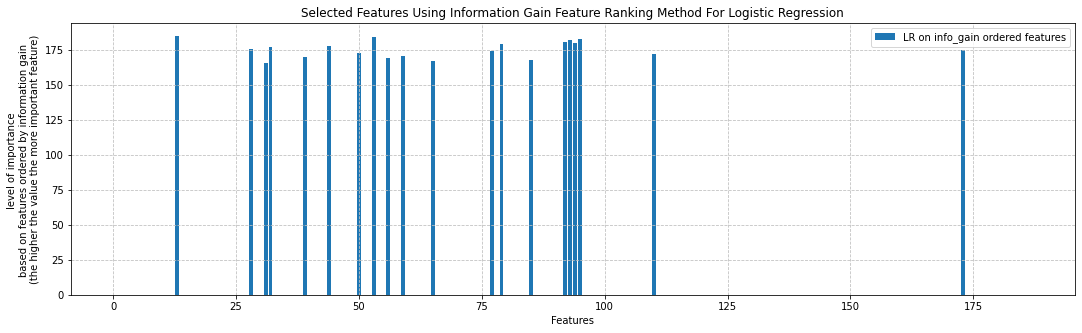

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.LR, label="LR on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

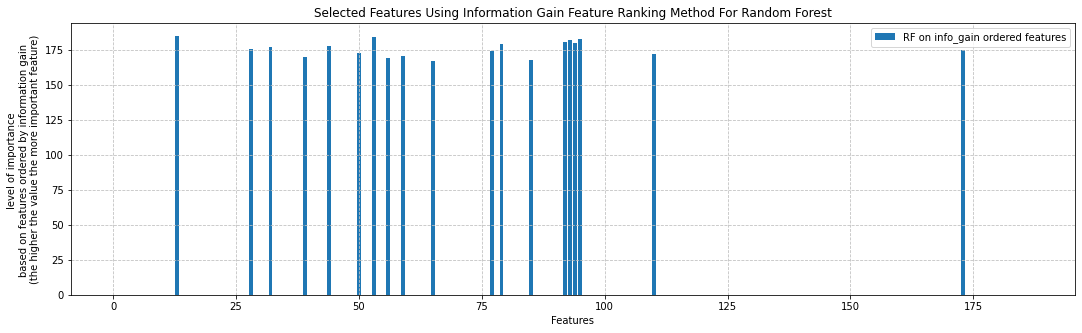

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.RF, label="RF on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

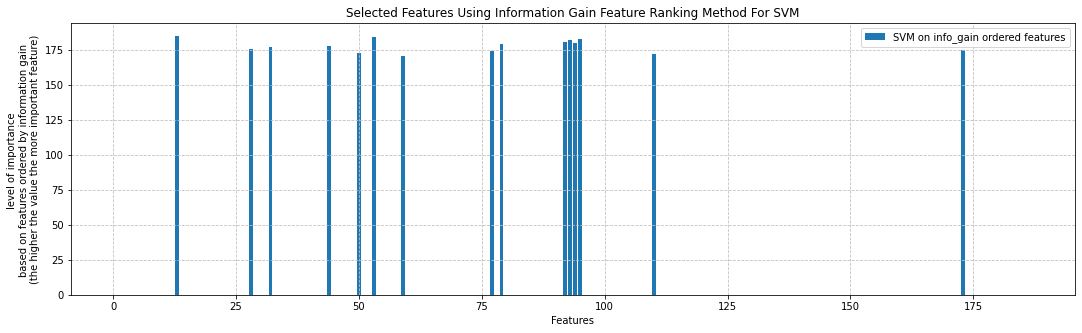

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SVM, label="SVM on info_gain ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features Using Information Gain Feature Ranking Method For SVM')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

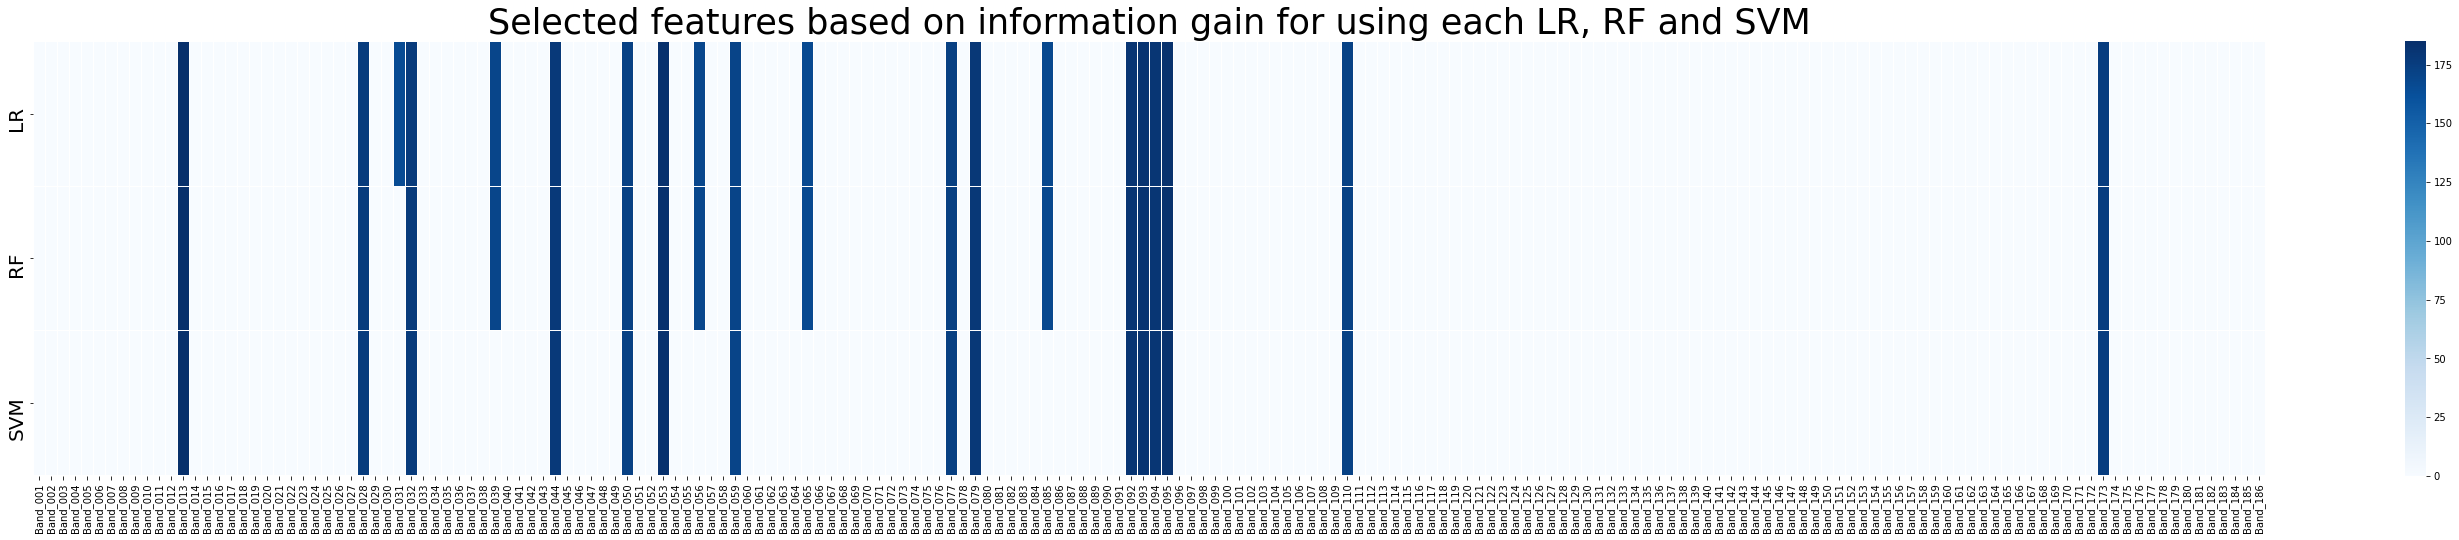

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features based on information gain for using each LR, RF and SVM', fontsize=35)
plt.yticks(fontsize=20)

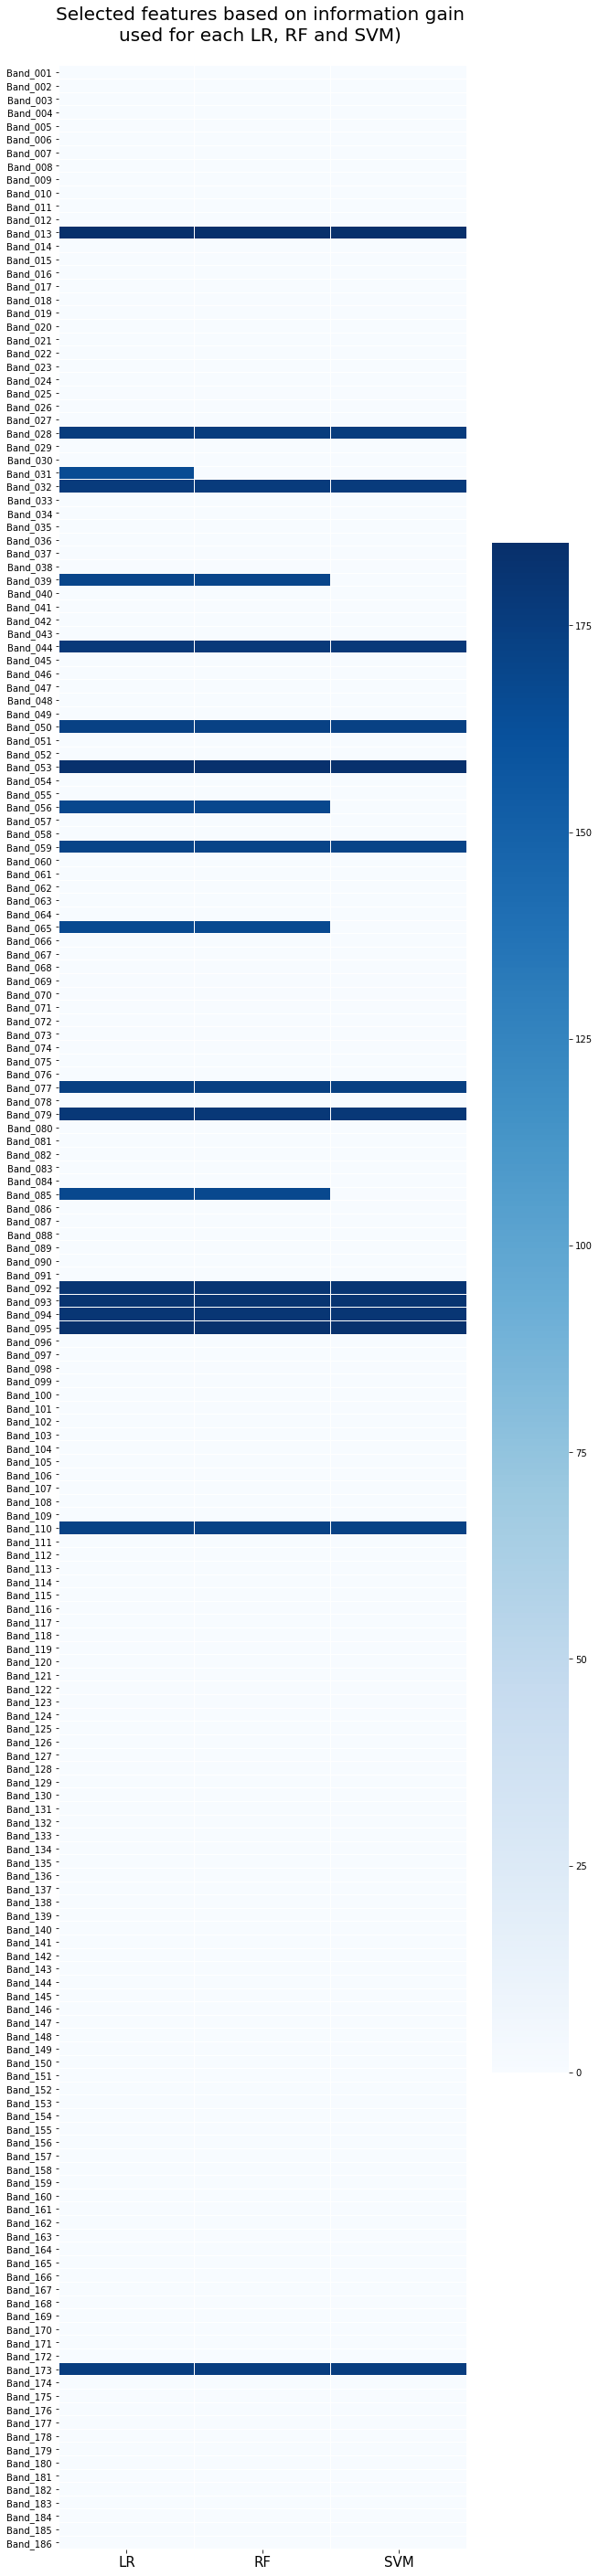

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features based on information gain \nused for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)